In [4]:
from tasks import preprocessing, util

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import os

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

INPUT_DIR = "input"
OUTPUT_DIR = "output"
INTERMEDIATE_DIR = "intermediate"

## Dataset

Acquiring and preprocessing our data with the goal of eventually acquiring a sufficient representation of our text is the most difficult and time-consuming task. We thus split it in distinct phases:

* Original dataset acquisition and parsing
* Qualitative analysis and preprocessing
* Transformation for the NLP task

Note that due to the relative custom code complexity, most of the code used in this section was developed and imported from python source files located in the `tasks` module. In-depth documentation and implementation details can be found in these files. 

In [6]:
print("Loading training dataset...")
train_df = preprocessing.conllu_to_pd("input/UD_English-EWT/en_ewt-ud-train.conllu")
print("Loading validation dataset...")
val_df = preprocessing.conllu_to_pd("input/UD_English-EWT/en_ewt-ud-dev.conllu")
print("Loading test dataset...")
test_df = preprocessing.conllu_to_pd("input/UD_English-EWT/en_ewt-ud-test.conllu")

print(f"Training data shape: {train_df.shape}\nValidation data shape: {val_df.shape}"
      "\nTest data shape: {test_df.shape}")

Loading training dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/12544 [00:00<?, ?it/s]

Loading validation dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/12544 [00:00<?, ?it/s]

Loading test dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/12544 [00:00<?, ?it/s]

Training data shape: (207227, 3)
Validation data shape: (207227, 3)
Test data shape: {test_df.shape}


Below we can see a preview of our parsed training dataset. Our preprocessing exploits pandas's ordering scheme in order to make sure the words are inserted in the order they appear in the sentence. This ordering will prove important later.

In [7]:
train_df

,words,pos,sent_id
0,al,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
1,-,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
2,zaman,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
3,:,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
4,american,ADJ,weblog-juancole.com_juancole_20051126063000_EN...
...,...,...,...
207222,on,ADP,reviews-319816-0029
207223,my,PRON,reviews-319816-0029
207224,car,NOUN,reviews-319816-0029
207225,),PUNCT,reviews-319816-0029


As mentioned above, our dataset features words connected with punctuation such as "don't". These are normally treated as two words, with the first being their intuitive POS tag ("do" - AUX) and the second as part of the first ("n't" - PART).

This dataset contains both the full words and their split versions, with only the latter featuring valid POS tags. The former are instead marked by a pseudo-tag (here "_").

In [8]:
invalid_idx = train_df.pos == "_"
train_df[invalid_idx]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
704,won't,_,weblog-juancole.com_juancole_20051126063000_EN...
868,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1058,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1078,doesn't,_,weblog-blogspot.com_healingiraq_20040409053012...
...,...,...,...
207078,couldn't,_,reviews-319816-0025
207091,don't,_,reviews-319816-0025
207096,employees',_,reviews-319816-0025
207164,i'm,_,reviews-319816-0027


In [9]:
" ".join(train_df[invalid_idx].words.unique()[:30])

"don't won't doesn't haven't didn't others it's elena's women's children's i'm people's musharraf's sharon's hamas's right's cannot isn't one's let's reporter's he's that's pakistan's world's bush's military's sharif's can't couldn't"

Below we can see an example of a word being contained both times in the dataset, one in full with the pseudo-tag, and the other as split words with valid POS tags.

In [10]:
train_df.iloc[176:179]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
177,do,AUX,weblog-juancole.com_juancole_20051126063000_EN...
178,n't,PART,weblog-juancole.com_juancole_20051126063000_EN...


We thus remove the full words including the pseudo-tag from our datasets, ensuring that all target POS tags will be compliant with the UPOS scheme.

In [11]:
train_df = train_df[~invalid_idx]
val_df = val_df[val_df.pos != "_"]
test_df = test_df[test_df.pos != "_"]

### Qualitative Analysis

We analyze our dataset in two granualities: sentences and individual words. We begin by analyzing how many words are in each sentence, which will give us an idea on the size of context available for each word.

In [12]:
def length_sentences(df: pd.DataFrame) -> float:
    lengths = df.groupby(["sent_id"]).agg(lambda x: len(x))
    return lengths.words


train_length = length_sentences(train_df)
val_length = length_sentences(val_df)
test_length = length_sentences(test_df)

Figured saved to output/ex_2_dataset_stats.png


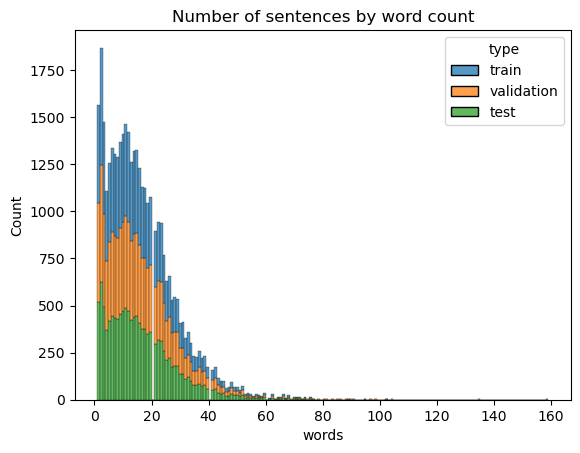

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


stats_df = pd.DataFrame({"words": pd.concat([train_length, val_length, test_length], ignore_index=True),
                        "type": len(train_length)*["train"] +
                         len(val_length)*["validation"] + 
                         len(test_length)*["test"]})

sns.histplot(x="words", 
             hue="type", 
             data=stats_df, 
             multiple="stack")

plt.title("Number of sentences by word count")
util.save_plot("ex_2_dataset_stats.png", OUTPUT_DIR)
plt.show()

In [14]:
train_length.describe()

count    12544.000000
mean        16.311703
std         12.404826
min          1.000000
25%          7.000000
50%         14.000000
75%         23.000000
max        159.000000
Name: words, dtype: float64

In [15]:
val_length.describe()

count    12544.000000
mean        16.311703
std         12.404826
min          1.000000
25%          7.000000
50%         14.000000
75%         23.000000
max        159.000000
Name: words, dtype: float64

In [16]:
test_length.describe()

count    12544.000000
mean        16.311703
std         12.404826
min          1.000000
25%          7.000000
50%         14.000000
75%         23.000000
max        159.000000
Name: words, dtype: float64

In [17]:
vocab_size = len(set(train_df.words))
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 16654


In [18]:
print(f"Total word count:\nTraining: {train_df.shape[0]}"
      f"\nValidation: {val_df.shape[0]}"
      f"\nTesting: {test_df.shape[0]}")

Total word count:
Training: 204614
Validation: 204614
Testing: 204614


In [19]:
print(f"Total sentence count:\nTraining: {len(set(train_df.sent_id))}"
      f"\nValidation: {len(set(val_df.sent_id))}"
      f"\nTesting: {len(set(test_df.sent_id))}")

Total sentence count:
Training: 12544
Validation: 12544
Testing: 12544


## Baseline Model

In [20]:
from tasks.models import BaselineLabelClassifier


x_base_train = train_df.words
x_base_valid = val_df.words
x_base_test = test_df.words

y_base_train = train_df.pos
y_base_valid = val_df.pos
y_base_test = test_df.pos

base_cls = BaselineLabelClassifier()
base_cls.fit(X=x_base_train, y=y_base_train)

BaselineLabelClassifier()

In [21]:
from sklearn.metrics import classification_report


training_preds = base_cls.predict(x_base_train)
print(classification_report(y_base_train, training_preds))

              precision    recall  f1-score   support

         ADJ       0.88      0.89      0.89     13152
         ADP       0.87      0.67      0.76     17795
         ADV       0.61      0.83      0.71     10113
         AUX       0.88      0.79      0.83     12828
       CCONJ       0.98      0.99      0.99      6688
         DET       0.96      0.95      0.95     16299
        INTJ       0.68      0.87      0.76       693
        NOUN       0.88      0.90      0.89     34813
         NUM       0.99      0.89      0.94      4126
        PART       0.71      0.89      0.79      5748
        PRON       0.90      0.95      0.93     18642
       PROPN       0.90      0.84      0.87     12325
       PUNCT       0.99      0.99      0.99     23597
       SCONJ       0.64      0.41      0.50      3839
         SYM       0.88      0.83      0.85       721
        VERB       0.83      0.89      0.86     22594
           X       0.86      0.64      0.74       641

    accuracy              

In [22]:
test_preds = base_cls.predict(x_base_test)
print(classification_report(y_base_test, test_preds))

              precision    recall  f1-score   support

         ADJ       0.88      0.89      0.89     13152
         ADP       0.87      0.67      0.76     17795
         ADV       0.61      0.83      0.71     10113
         AUX       0.88      0.79      0.83     12828
       CCONJ       0.98      0.99      0.99      6688
         DET       0.96      0.95      0.95     16299
        INTJ       0.68      0.87      0.76       693
        NOUN       0.88      0.90      0.89     34813
         NUM       0.99      0.89      0.94      4126
        PART       0.71      0.89      0.79      5748
        PRON       0.90      0.95      0.93     18642
       PROPN       0.90      0.84      0.87     12325
       PUNCT       0.99      0.99      0.99     23597
       SCONJ       0.64      0.41      0.50      3839
         SYM       0.88      0.83      0.85       721
        VERB       0.83      0.89      0.86     22594
           X       0.86      0.64      0.74       641

    accuracy              

## MLP Classifier

In [23]:
def exclude_small_sentences(conllu_df: pd.DataFrame, min_len: int) -> pd.DataFrame:
    assert 1 <= min_len

    length_df = length_sentences(conllu_df)
    valid_length_df = length_df[length_df >= min_len]
    valid_ids = set(valid_length_df.index)
    return conllu_df[conllu_df.sent_id.isin(valid_ids)]

In [24]:
MIN_SENTENCE_LENGTH = 5
WINDOW_SIZE = 5
TRAINING_LIM = 150000
VALID_LIM = 25000
TEST_LIM = 10000
SEED = 42
PAD_TOKEN = "<PAD>"

In [25]:
train_df_filt = exclude_small_sentences(train_df, MIN_SENTENCE_LENGTH)
val_df_filt = exclude_small_sentences(val_df, MIN_SENTENCE_LENGTH)
test_df_filt = exclude_small_sentences(test_df, MIN_SENTENCE_LENGTH)

train_df_filt

,words,pos,sent_id
0,al,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
1,-,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
2,zaman,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
3,:,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
4,american,ADJ,weblog-juancole.com_juancole_20051126063000_EN...
...,...,...,...
207222,on,ADP,reviews-319816-0029
207223,my,PRON,reviews-319816-0029
207224,car,NOUN,reviews-319816-0029
207225,),PUNCT,reviews-319816-0029


In [26]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Bidirectional, GRU,\
                                    TextVectorization, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy

from sklearn.preprocessing import LabelBinarizer

In [27]:
# download and unzip only if the download and unzipped files do not exist 
!wget -nc -P input/fasttext https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

![ -f "input/fasttext/cc.en.300.bin" ] && echo "Skipping model file" || gzip --decompress --keep --force "input/fasttext/cc.en.300.bin.gz"   

File ‘input/fasttext/cc.en.300.bin.gz’ already there; not retrieving.

Skipping model file


In [28]:
import fasttext 


print("Loading embedding model...")
fasttext_model = fasttext.load_model('input/fasttext/cc.en.300.bin')

Loading embedding model...


In [31]:
(
    x_train_mlp,
    x_valid_mlp,
    x_test_mlp,
    y_train_mlp,
    y_valid_mlp,
    y_test_mlp,
    lb_mlp,
) = preprocessing.mlp_input(
    train_df_filt,
    val_df_filt,
    test_df_filt,
    embed_model=fasttext_model,
    intermediate_dir=INTERMEDIATE_DIR,
    train_lim=TRAINING_LIM,
    val_lim=VALID_LIM,
    test_lim=TEST_LIM,
    window_size=WINDOW_SIZE,
    seed=SEED,
    pad_token=PAD_TOKEN,
)

Attempting to load intermediate calculations...
No intermediate files present, calculating from scratch.
Processing training dataset...
Calculating windows...


  0%|          | 0/10539 [00:00<?, ?it/s]

Calculating targets...


  0%|          | 0/10539 [00:00<?, ?it/s]

Computing window embeddings...


  0%|          | 0/150000 [00:00<?, ?it/s]

Processing validation dataset...
Calculating windows...


  0%|          | 0/10539 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
mlp = keras.saving.load_model(os.path.join("model.keras"))

train_preds_mlp = mlp.predict(x_train_mlp)
val_preds_mlp = mlp.predict(x_valid_mlp)
test_preds_mlp = mlp.predict(x_test_mlp)

## Creating the RNN model

### Vectorization

In [ ]:
lb = LabelBinarizer()

y_train = lb.fit_transform(train_df.pos)
y_valid = lb.transform(val_df.pos)
y_test = lb.transform(test_df.pos)


In [ ]:
MAX_SEQUENCE_LENGTH = int(np.quantile(train_length, 0.95))
MAX_SEQUENCE_LENGTH

In [ ]:
MAX_WORDS = vocab_size
EMBEDDING_DIM = 300

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS, output_mode='int', ngrams=1, 
              output_sequence_length=MAX_SEQUENCE_LENGTH)

print("Setting up vectorizer...")
vectorizer.adapt(train_df.words.values)

### Word embeddings

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
print("Executing with ", gpus[0].name if len(gpus) != 0 else "CPU")

In [ ]:
embedding_matrix = np.zeros(shape=(MAX_WORDS, 300))

print("Computing word embeddings...")
for w2idx, _word in tqdm(enumerate(vectorizer.get_vocabulary()), 
                          total = len(vectorizer.get_vocabulary())):
    # Skip PAD and UNK tokens
    if w2idx < 2:
      continue
    embedding_matrix[w2idx] = fasttext_model.get_word_vector(_word)

# reclaim memory
del fasttext_model

(https://arxiv.org/pdf/1801.05134.pdf)

In [ ]:
GRU_SIZE = 300
DENSE = 1000


# create empty sequential model
model = tf.keras.Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorizer)

model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))

model.add(Bidirectional(GRU(GRU_SIZE, return_sequences=True)))
model.add(LayerNormalization())

model.add(Bidirectional(GRU(GRU_SIZE, return_sequences=False)))
model.add(LayerNormalization())

# add an MLP with 1 hidden layer
model.add(Dense(units=DENSE, activation='tanh' ))
model.add(Dropout(0.33))
model.add(Dense(len(np.unique(train_df.pos)), activation='softmax'))

print(model.summary())

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=["categorical_accuracy"])

train_data = train_df.words.values
val_data = val_df.words.values

history = model.fit(train_data, y_train,
              validation_data=(val_data, y_valid),
              batch_size=256,
              epochs=10,
              shuffle=True,
              callbacks=[util.Metrics(valid_data=(val_data, y_valid))])